# Creating pathfinder subsample

June 21, 2022  
Gully & Ryan H.

The goal of this notebook is to make the pathfinder sample.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightkurve as lk
from tqdm import tqdm
import time
import astropy.units as u


sns.set_context('notebook', font_scale=1.5)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
names = ['EPIC','Campaign','Teff','log g','Prot','ΔProt','hpeak','Rvar','Kp','MG']

In [3]:
df = pd.read_csv('../../data/Reinhold_Hekker2020/table2.dat', 
                 delim_whitespace=True, names=names, na_values='---')

Looks good!  We see the same trend we had in our proposal figure 2.

## Select a subsample of sources

First search for some high amplitude variable stars

In [4]:
criterion1 = (df.Prot > 1) & (df.Prot < 10)
criterion2 = (df.Rvar > 0.5) & (df.Rvar < 20)
criterion3 = (df.Teff > 4000) & (df.Teff < 4500)
criteria = criterion1 & criterion2 & criterion3

In [5]:
criteria.sum()

416

Text(0.5, 1.0, 'Reinhold & Hekker 2020 Table 2')

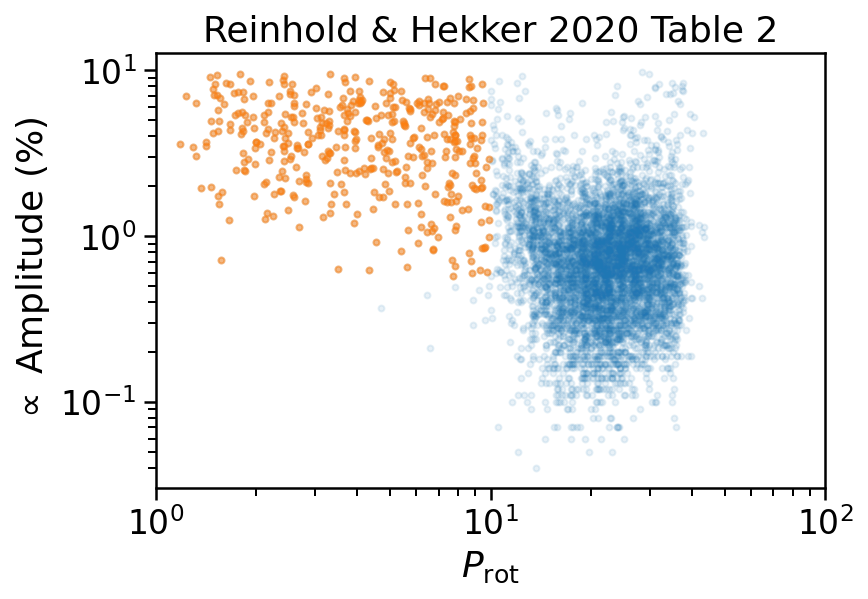

In [6]:
#plt.plot(df.Prot, df.Rvar, '.', alpha=0.02);
plt.plot(df.Prot[criterion3], df.Rvar[criterion3], '.', alpha=0.1);
plt.plot(df.Prot[criteria], df.Rvar[criteria], '.', alpha=0.5);
#plt.ylim(3e2, 2e5)
plt.xlim(1e0, 1e2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$P_{\mathrm{rot}}$')
plt.ylabel('$\propto$ Amplitude (%)')
plt.title('Reinhold & Hekker 2020 Table 2')

In [7]:
df[criteria].head()

,EPIC,Campaign,Teff,log g,Prot,ΔProt,hpeak,Rvar,Kp,MG
7,202059229,0,4161,4.78,4.93,0.32,0.44,2.39,10.5,8.06
79,202068593,0,4180,4.78,3.09,0.26,0.87,4.36,15.8,NaN
141,202083650,0,4160,4.77,2.41,0.24,0.59,9.26,15.8,NaN
149,202084291,0,4027,4.81,2.40,0.24,0.40,3.48,14.6,NaN
178,202085463,0,4044,4.81,9.02,0.53,0.91,2.39,15.2,0.35


In [8]:
df_subset=df[criteria].reset_index(drop=True)

In [9]:
df_subset

,EPIC,Campaign,Teff,log g,Prot,ΔProt,hpeak,Rvar,Kp,MG
0,202059229,0,4161,4.78,4.93,0.32,0.44,2.39,10.50,8.06
1,202068593,0,4180,4.78,3.09,0.26,0.87,4.36,15.80,NaN
2,202083650,0,4160,4.77,2.41,0.24,0.59,9.26,15.80,NaN
3,202084291,0,4027,4.81,2.40,0.24,0.40,3.48,14.60,NaN
4,202085463,0,4044,4.81,9.02,0.53,0.91,2.39,15.20,0.35
...,...,...,...,...,...,...,...,...,...,...
411,212019656,18,4106,4.78,1.81,0.22,0.58,4.48,14.88,8.05
412,212035632,18,4050,4.80,3.23,0.26,0.84,4.77,15.22,NaN
413,212106975,18,4030,4.79,1.49,0.21,0.52,7.08,16.78,NaN
414,212129124,18,4153,4.78,6.70,0.40,0.56,2.77,16.01,10.05


## Make a subsub sample

### Prepopulate our columns

In [10]:
df_subset['N_EVEREST'] = np.NaN
df_subset['N_TESS_SPOC'] = np.NaN
df_subset['Period_TESS'] = 0
df_subset['Amplitude_TESS'] = 0
df_subset['Period_K2'] = 0
df_subset['Amplitude_K2'] = 0
df_subset['Sector'] = np.NaN

In [11]:
df_tiny = df_subset.head(15)
df_tiny

,EPIC,Campaign,Teff,log g,Prot,ΔProt,hpeak,Rvar,Kp,MG,N_EVEREST,N_TESS_SPOC,Period_TESS,Amplitude_TESS,Period_K2,Amplitude_K2,Sector
0,202059229,0,4161,4.78,4.93,0.32,0.44,2.39,10.50,8.06,NaN,NaN,0,0,0,0,NaN
1,202068593,0,4180,4.78,3.09,0.26,0.87,4.36,15.80,NaN,NaN,NaN,0,0,0,0,NaN
2,202083650,0,4160,4.77,2.41,0.24,0.59,9.26,15.80,NaN,NaN,NaN,0,0,0,0,NaN
3,202084291,0,4027,4.81,2.40,0.24,0.40,3.48,14.60,NaN,NaN,NaN,0,0,0,0,NaN
4,202085463,0,4044,4.81,9.02,0.53,0.91,2.39,15.20,0.35,NaN,NaN,0,0,0,0,NaN
5,201189968,1,4446,4.68,2.59,0.24,0.41,1.73,13.86,7.08,NaN,NaN,0,0,0,0,NaN
6,201196841,1,4199,4.76,7.62,0.45,0.68,1.60,15.10,6.76,NaN,NaN,0,0,0,0,NaN
7,201232485,1,4193,4.76,2.92,0.25,0.51,3.92,16.04,NaN,NaN,NaN,0,0,0,0,NaN
8,201234609,1,4220,4.75,7.76,0.45,0.76,6.31,15.18,NaN,NaN,NaN,0,0,0,0,NaN
9,201245978,1,4339,4.73,7.67,0.45,0.72,0.72,14.81,7.05,NaN,NaN,0,0,0,0,NaN


In [12]:
df_tiny.iloc[0].to_frame()

,0
EPIC,2.020592e+08
Campaign,0.000000e+00
Teff,4.161000e+03
log g,4.780000e+00
Prot,4.930000e+00
ΔProt,3.200000e-01
hpeak,4.400000e-01
Rvar,2.390000e+00
Kp,1.050000e+01
MG,8.060000e+00


### Predownload so that it runs faster later

Let's find one of the sources that *also* has TESS data available

Delete the cell below if you want to run on the entire subset of 400+ sources...

In [13]:
df_subset = df_tiny

In [14]:
n_sources = len(df_subset)
n_sources

15

We want to have at least 1 EVEREST lightcurve and 1 SPOC lightcurve for all sources.

In [15]:
def download(name, mission, idx):
    if mission == 'TESS':
        sr = lk.search_lightcurve(name, mission=mission)
        df_subset.loc[idx, 'N_TESS_SPOC'] = len(sr)
    elif mission == 'K2':
        sr = lk.search_lightcurve(name, mission=mission, author='EVEREST')
        df_subset.loc[idx, 'N_EVEREST'] = len(sr)

    if len(sr) > 0:
        try:
            # download the data for the lightcurve
            lc = sr[0].download()
            add_data(mission, idx, lc)
        except:
            lc = sr[1].download()
            add_data(mission, idx, lc)
        finally:
            return

def add_data(mission, idx, lc):
        # remove NaNs and normalize the data        
        lc = lc.remove_nans().remove_outliers()

        # find the amplitude percentage
        vector = lc.flux.value
        lo, hi = np.percentile(vector, (5, 95))
        peak_to_valley = hi-lo

        # add the data to the table
        df_subset.loc[idx, f'Amplitude_{mission}'] = peak_to_valley

        # change the lightcurve into a periodogram and find its period
        period = float(lc.to_periodogram().period_at_max_power.to_value())

        # add the period to the data table
        df_subset.loc[idx, f'Period_{mission}'] = period

        if mission == "TESS":
            # find the sector number and add it to the data table
            df_subset.loc[idx, 'Sector'] = lc.sector

In [16]:
%%capture
start = time.time()
for i in tqdm(range(n_sources)):
    # find the name of the star
    name = 'EPIC ' + df_subset.iloc[i].EPIC.astype(int).astype(str)
    download(name, 'TESS', i)
    download(name, 'K2', i)
end = time.time()

No data found for target "EPIC 202068593".
No data found for target "EPIC 202083650".
No data found for target "EPIC 202084291".
No data found for target "EPIC 202085463".
No data found for target "EPIC 201189968".
No data found for target "EPIC 201196841".
No data found for target "EPIC 201232485".
No data found for target "EPIC 201234609".
No data found for target "EPIC 201245978".
No data found for target "EPIC 201318977".
No data found for target "EPIC 201363197".
No data found for target "EPIC 201377225".
No data found for target "EPIC 201429915".
No data found for target "EPIC 201457244".


In [17]:
df_subset

,EPIC,Campaign,Teff,log g,Prot,ΔProt,hpeak,Rvar,Kp,MG,N_EVEREST,N_TESS_SPOC,Period_TESS,Amplitude_TESS,Period_K2,Amplitude_K2,Sector
0,202059229,0,4161,4.78,4.93,0.32,0.44,2.39,10.50,8.06,1.0,9.0,2.474142,551.036719,5.109315,35669.203445,6.0
1,202068593,0,4180,4.78,3.09,0.26,0.87,4.36,15.80,NaN,1.0,0.0,0.000000,0.000000,3.115436,148.246212,NaN
2,202083650,0,4160,4.77,2.41,0.24,0.59,9.26,15.80,NaN,1.0,0.0,0.000000,0.000000,76.639504,146621.919847,NaN
3,202084291,0,4027,4.81,2.40,0.24,0.40,3.48,14.60,NaN,1.0,0.0,0.000000,0.000000,63.866205,13948.732918,NaN
4,202085463,0,4044,4.81,9.02,0.53,0.91,2.39,15.20,0.35,1.0,0.0,0.000000,0.000000,8.911571,694.080263,NaN
5,201189968,1,4446,4.68,2.59,0.24,0.41,1.73,13.86,7.08,1.0,0.0,0.000000,0.000000,0.000000,0.000000,NaN
6,201196841,1,4199,4.76,7.62,0.45,0.68,1.60,15.10,6.76,1.0,0.0,0.000000,0.000000,200.181120,271.958476,NaN
7,201232485,1,4193,4.76,2.92,0.25,0.51,3.92,16.04,NaN,1.0,0.0,0.000000,0.000000,2.880300,218.508737,NaN
8,201234609,1,4220,4.75,7.76,0.45,0.76,6.31,15.18,NaN,1.0,0.0,0.000000,0.000000,7.699260,768.675620,NaN
9,201245978,1,4339,4.73,7.67,0.45,0.72,0.72,14.81,7.05,1.0,0.0,0.000000,0.000000,7.699264,145.154056,NaN


In [18]:
end-start

39.20106291770935

## Complitation times

**15 Stars:**  
Desktop:  
fresh download time ~ 42 seconds  
pre-downloaded time ~ 33.65 seconds  
cached time ~ 2.6 seconds  
  

Laptop:  
fresh download time ~ 46 seconds  
pre-downloaded time ~ 33.8 seconds  
cached time ~ 2.39 seconds  

------------------------------------------------------------  

**416 Stars:**  
Desktop:  
fresh download time ~ 1359.3 seconds ~ 22.6 minutes  
pre-downloaded time ~ 808 seconds ~ 13.5 minutes  
cached time ~ 100 seconds  
  

Laptop:  
fresh download time ~ 1747.5 seconds ~ 29.1 minutes  
pre-downloaded time ~ 936.8 seconds ~ 15.6 minutes  
cached time ~ 66.4 seconds  

In [ ]:
df_subset.to_csv('pathfinder_sample.csv', index=False)

## Spot check one source...

In [32]:
name = 'EPIC 202083650'

In [33]:
lc_tess = lk.search_lightcurve(name, author='EVEREST')
len(lc_tess)
#lc_tess.plot()

1

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

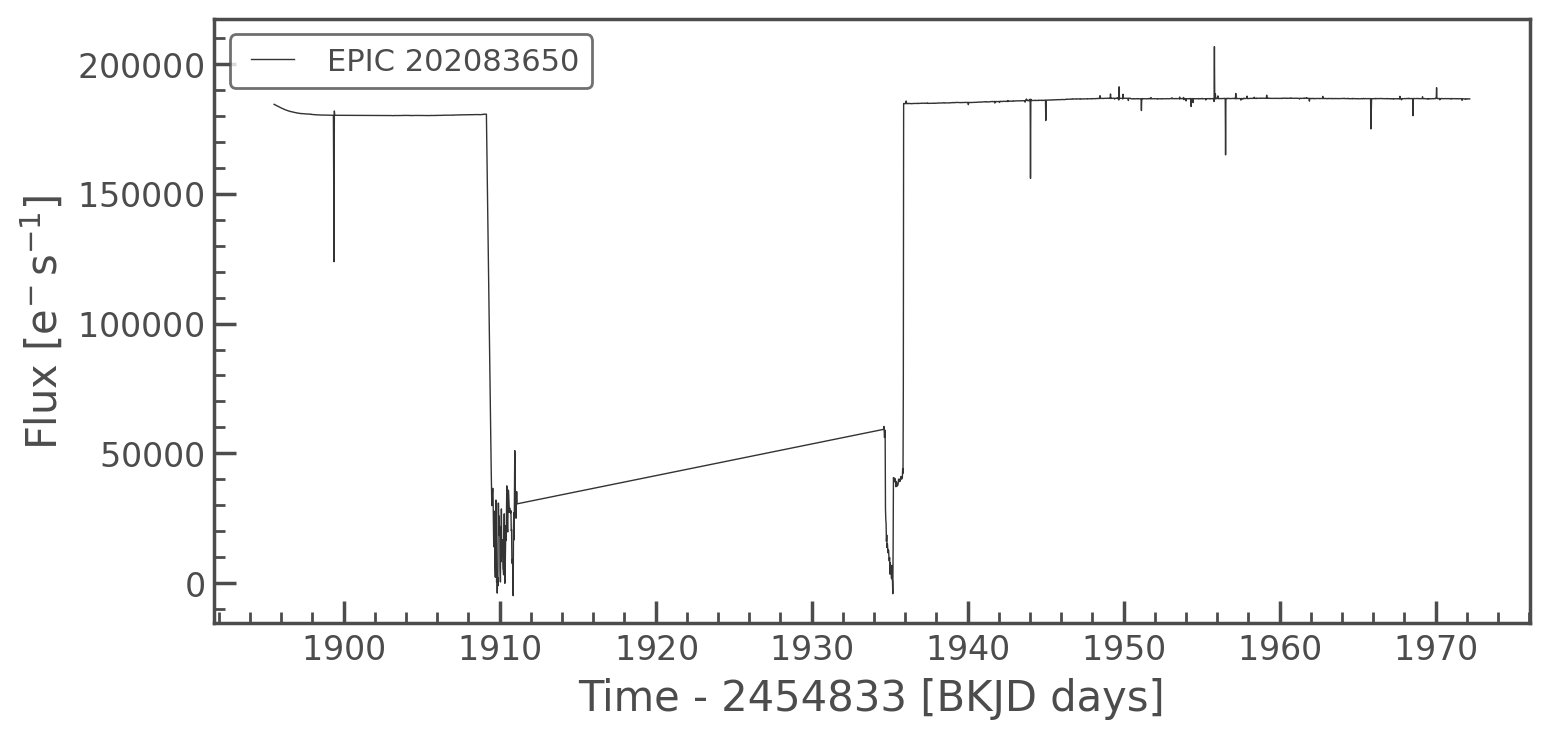

In [37]:
lc = lk.search_lightcurve(name, author="EVEREST")[0].download().remove_nans().remove_outliers()#.normalize().flatten()
lc.plot()#.to_periodogram().plot()

<AxesSubplot:xlabel='Frequency [$\\mathrm{\\frac{1}{d}}$]', ylabel='Power [$\\mathrm{\\frac{e^{-}}{s}}$]'>

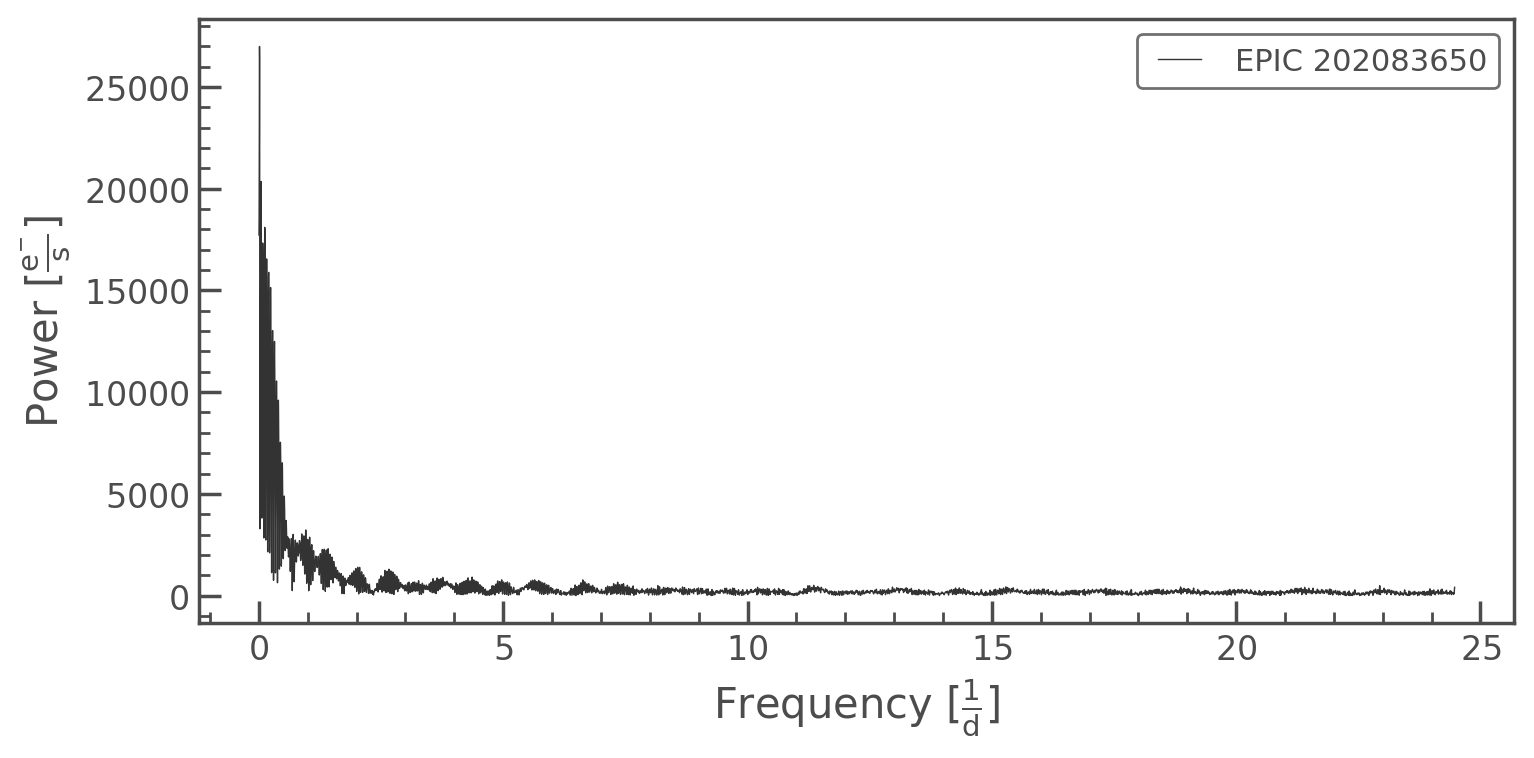

In [38]:
pg = lc.to_periodogram()
pg.plot()

In [39]:
pg.period_at_max_power

<Quantity 76.63950441 d>

In [ ]:
name = 'EPIC 220205464'

In [ ]:
df_subset.iloc[236].EPIC

In [ ]:
download(name, "TESS", 236)

In [ ]:
tpf = lk.search_targetpixelfile('EPIC 246979864', author='K2').download()
pld = lk.correctors.PLDCorrector(tpf)
corrected_lc = pld.correct().remove_outliers().to_periodogram().period_at_max_power
corrected_lc.to_periodogram().period_at_max_power

## Plotting the data

In [ ]:
plt.figure(figsize=(6,6))
plt.ylim(0.5, 10)
plt.xlim(0.5, 10)
plt.xlabel('$P_{\mathrm{Kepler}}$')
plt.ylabel('$P_{\mathrm{TESS}}$')
plt.title('Comparison between TESS and Kepler amplitudes')

x = [0.5, 10]
y = [0.5, 10]
plt.plot(x, y)

# plt.xticks(1)
# plt.yscale()

plt.plot(df_subset.Period_K2, df_subset.Period_TESS, 'r.')

plt.show()

## Receate fig2.pdf plot from proposal

In [ ]:
plt.plot(df_subset.Period_K2, df_subset.Amplitude_K2, '.', color='black')
plt.plot(df_subset.Period_TESS, df_subset.Amplitude_TESS, '.', color='red')

# plt.ylim(3e2, 2e5)
# plt.xlim(1e0, 1e2)

plt.xscale('log')
plt.yscale('log')

plt.axhline(1e3, linestyle='dotted', label='1%', color='purple')
plt.axvline(27, linestyle='dashed', label='27 days', color='purple')
plt.legend()
plt.legend(fontsize=12)

plt.xlabel('$P_{\mathrm{rot}}$')
plt.ylabel('$\propto$ Amplitude (%)')
plt.title('Predicted for 4000 < $T_{\mathrm{eff}}$ < 4500 in TESS')

### Example manipulations ...

In [ ]:
sr.table.to_pandas()

In [ ]:
mask = (sr.table['author'] == 'EVEREST').data
mask.sum()

In [ ]:
sr = lk.search_lightcurve("EPIC 202059229", mission='TESS')
sr
lc = sr[0].download()

In [ ]:
lc = lc.remove_nans().normalize()

In [ ]:
vector = lc.flux.value
vector

In [ ]:
lo, hi = np.percentile(vector, (5, 95))

In [ ]:
lo, hi

In [ ]:
ax = lc.normalize().plot()
ax.axhline(hi)
ax.axhline(lo)

In [ ]:
peak_to_valley = hi-lo
peak_to_valley

In [ ]:
type(sr)

In [ ]:
df_sr = sr.table.to_pandas()

In [ ]:
df_subset

In [ ]:
len(sr)

In [19]:
sr = lk.search_lightcurve("EPIC 211071889", author="EVEREST", mission="K2")
sr

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,K2 Campaign 04,2015,EVEREST,1800,ktwo211071889,0.0


In [20]:
lc_K2 = sr.download()

In [21]:
sr = lk.search_lightcurve("EPIC 211071889", author="SPOC", mission="TESS")
sr[0]

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 42,2021,SPOC,120,35205530,0.0


In [22]:
lc_TESS = sr[0].download()

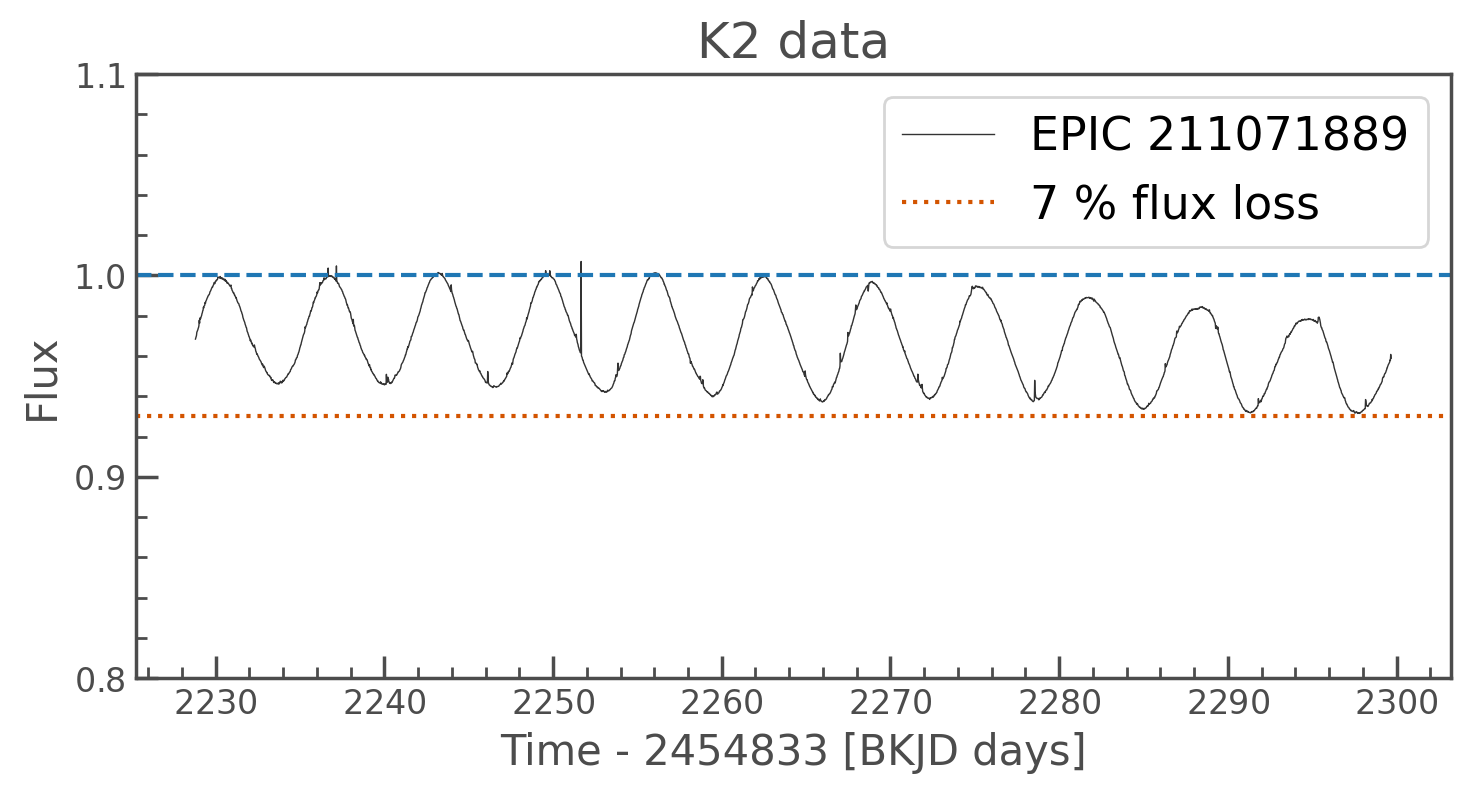

In [23]:
scalar = np.percentile(lc_K2.flux, 98)
lc_K2 = lc_K2/scalar
ax = lc_K2.plot()
ax.axhline(1.0, linestyle='dashed')
ax.axhline(0.93, linestyle='dotted', color='#d35400', label='7 % flux loss')
ax.set_title('K2 data')
ax.set_ylim(0.8, 1.1)
ax.legend()

In [24]:
lc_TESS = lc_TESS.remove_nans().bin(binsize=5)
scalar = np.nanpercentile(lc_TESS.flux, 98)
lc_TESS = lc_TESS/scalar

C:\Users\txrya\AppData\Local\Temp\ipykernel_34992\2697819001.py:1: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  lc_TESS = lc_TESS.remove_nans().bin(binsize=5)


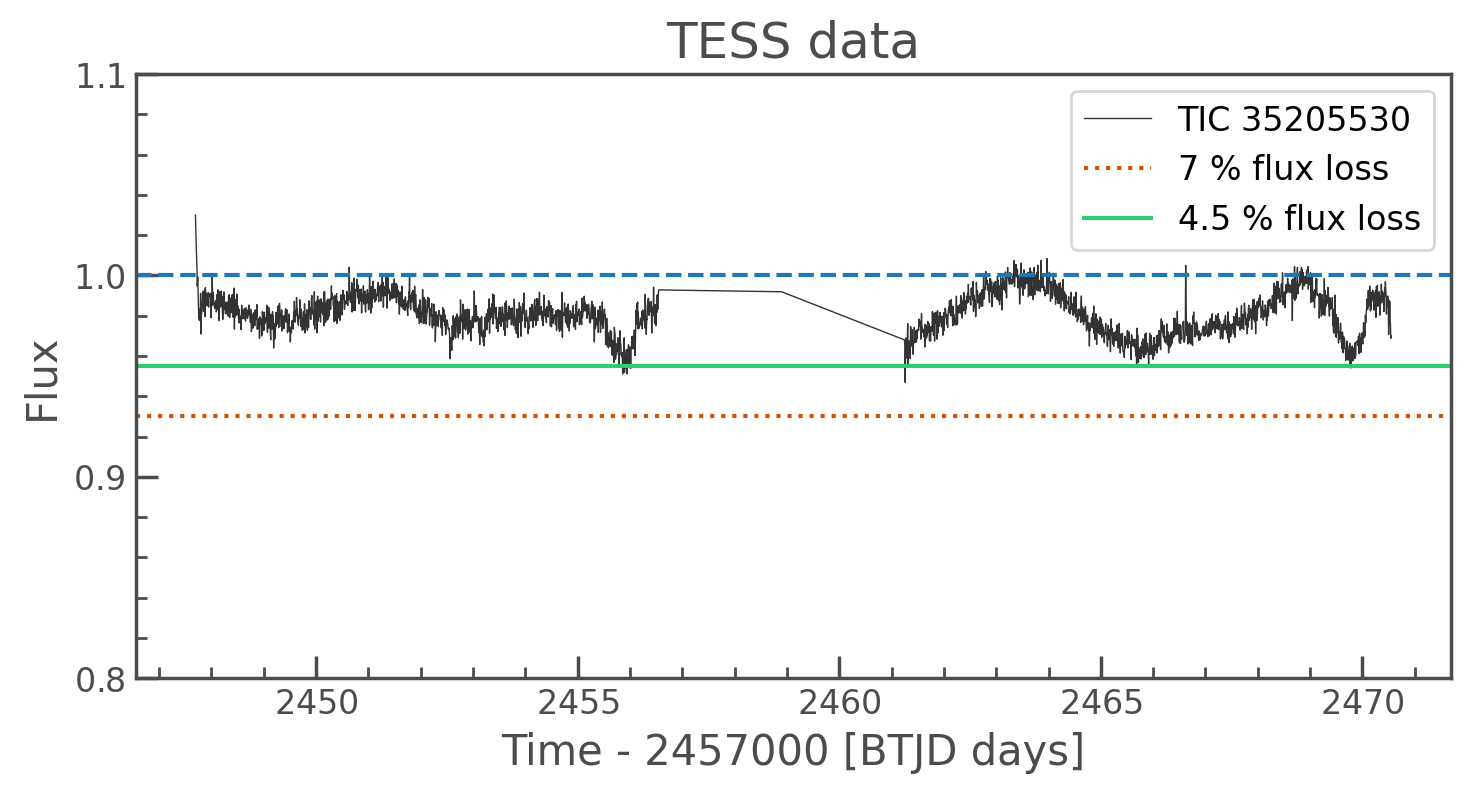

In [25]:
ax = lc_TESS.plot()
ax.axhline(1.0, linestyle='dashed')
ax.axhline(0.93, linestyle='dotted', color='#d35400', label='7 % flux loss')
ax.axhline(0.955, linestyle='solid', color='#2ecc71', label='4.5 % flux loss')
ax.set_title('TESS data')
ax.set_ylim(0.8, 1.1)
ax.legend(fontsize=12)

In [ ]:
assert len(sr) == 1

In [26]:
lc=sr.download()

C:\Users\txrya\miniconda3\lib\site-packages\lightkurve\search.py:346: LightkurveWarning: Warning: 3 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


In [27]:
lc = lc.remove_outliers(sigma=4,sigma_upper=3).normalize()

In [28]:
pg = lc.to_periodogram(nterms=5)

C:\Users\txrya\miniconda3\lib\site-packages\lightkurve\periodogram.py:932: LightkurveWarning: Building a Lomb Scargle Periodogram using the `slow` method. `nterms` has been set to >1, however this is not supported under the `fast` method. To run with higher nterms, set `ls_method` to either 'fastchi2', or 'chi2'. Please refer to the `astropy.timeseries.periodogram.LombScargle` documentation.
  warnings.warn(


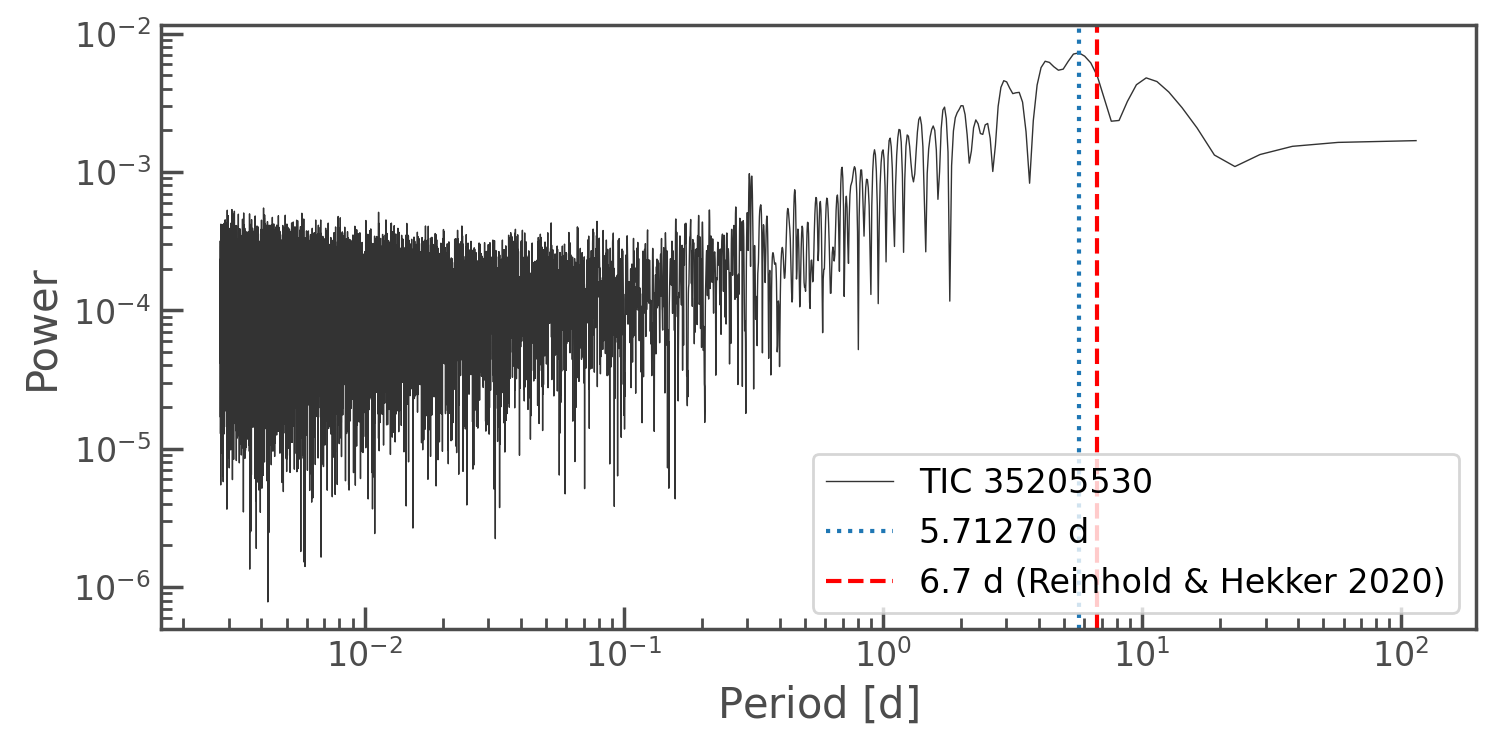

In [29]:
ax = pg.plot(view='period', scale='log')
ax.axvline(pg.period_at_max_power.value, linestyle='dotted', label=f'{pg.period_at_max_power:0.5f}')
ax.axvline(6.70, linestyle='dashed', label='6.7 d (Reinhold & Hekker 2020)', color = 'red')
ax.legend(fontsize = 12)

In [30]:
pg.period_at_max_power

<Quantity 5.71270114 d>

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

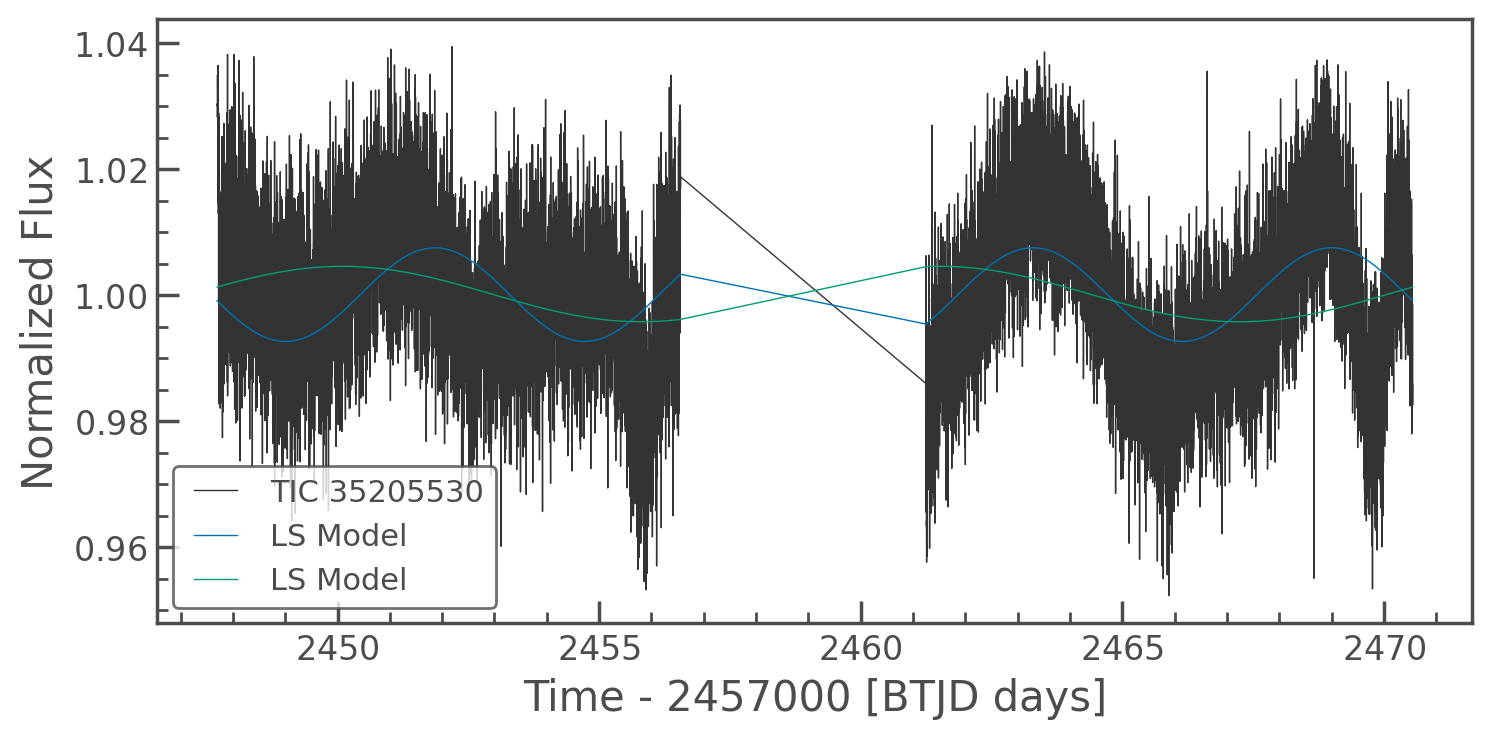

In [31]:
ax = lc.plot()
pg.model(lc.time).plot(ax=ax)
pg.model(lc.time, frequency=pg.frequency_at_max_power/2).plot(ax=ax)